<a href="https://colab.research.google.com/github/gr3g-z/TCC-PUCSP-CDIA/blob/secondary/Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df_test = pd.read_csv('/content/drive/MyDrive/store_sales/test.csv')
df_treino = pd.read_csv('/content/drive/MyDrive/store_sales/train.csv')
transactions = pd.read_csv('/content/drive/MyDrive/store_sales/transactions.csv')
feriados = pd.read_csv('/content/drive/MyDrive/store_sales/holidays_events.csv')
oil = pd.read_csv('/content/drive/MyDrive/store_sales/oil.csv')
stores = pd.read_csv('/content/drive/MyDrive/store_sales/stores.csv')
sample = pd.read_csv('/content/drive/MyDrive/store_sales/sample_submission.csv')

In [4]:
transactions

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


In [5]:
# Carregar o DataFrame do arquivo pickle
df_clusterizado = pd.read_pickle('/content/drive/MyDrive/store_sales/df_clusterizado.pkl')
# Renomear a coluna 'A' para 'Nova_Coluna'
df_clusterizado = df_clusterizado.rename(columns={'loja': 'store_nbr'})
df_clusterizado

,store_nbr,Soma vendas totais,Contagem vendas totais,Media por venda,Dias com dados,Media do faturamento por dia,Media de vendas por dia,cluster
0,1,1.414501e+07,2553963,5.538456,1694,8350.066629,1507.652302,0
1,2,2.155739e+07,3219901,6.695047,1694,12725.731195,1900.768005,2
2,3,5.048191e+07,5366350,9.407122,1695,29782.837867,3165.988201,1
3,4,1.890970e+07,2519007,7.506807,1695,11156.165416,1486.139823,0
4,5,1.559240e+07,2347877,6.641065,1695,9199.058745,1385.178171,0
5,6,2.518368e+07,3065896,8.214134,1695,14857.628317,1808.788201,2
6,7,2.695205e+07,2995993,8.996032,1695,15900.914208,1767.547493,2
7,8,3.049429e+07,4637971,6.574920,1695,17990.729751,2736.266077,2
8,9,2.640944e+07,3516162,7.510872,1695,15580.791189,2074.431858,2
9,10,9.613906e+06,1652493,5.817819,1695,5671.920788,974.922124,0


In [6]:
# Renomeando a coluna "store_nbr" do df_clusterizado para evitar conflitos
df_clusterizado.rename(columns={"store_nbr": "store_nbr_cluster"}, inplace=True)
# Mesclando os dataframes com base na coluna "store_nbr"
transactions = pd.merge(transactions, df_clusterizado[['store_nbr_cluster', 'cluster']], left_on='store_nbr', right_on='store_nbr_cluster', how='left')
# Removendo a coluna adicional "store_nbr_cluster" após a mesclagem, se desejar
transactions.drop(columns=['store_nbr_cluster'], inplace=True)

In [7]:
transactions

,date,store_nbr,transactions,cluster
0,2013-01-01,25,770,0
1,2013-01-02,1,2111,0
2,2013-01-02,2,2358,2
3,2013-01-02,3,3487,1
4,2013-01-02,4,1922,0
...,...,...,...,...
83483,2017-08-15,50,2804,2
83484,2017-08-15,51,1573,2
83485,2017-08-15,52,2255,2
83486,2017-08-15,53,932,0


In [8]:
transactions.isnull().any()

date            False
store_nbr       False
transactions    False
cluster         False
dtype: bool

In [9]:
transactions.isnull().values.any()

False

In [10]:
nulos = transactions.isnull().sum()  # Conta a quantidade de valores nulos (incluindo `nan`) em cada coluna
print(nulos)

date            0
store_nbr       0
transactions    0
cluster         0
dtype: int64


<ipython-input-11-5f78ee37e241>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grande['date'] = pd.to_datetime(df_grande['date'])
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaxps5sz7/azs7hln1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaxps5sz7/uip9wnx6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5402', 'data', 'file=/tmp/tmpaxps5sz7/azs7hln1.json', 'init=/tmp/tmpaxps5sz7/uip9wnx6.json', 'output', 'file=/tmp/tmpaxps5sz7/prophet_modelooxll1nv/prophet_model-20240412023841.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:38:41 - cmdstanpy - INFO - Chain [1] start processing
INF

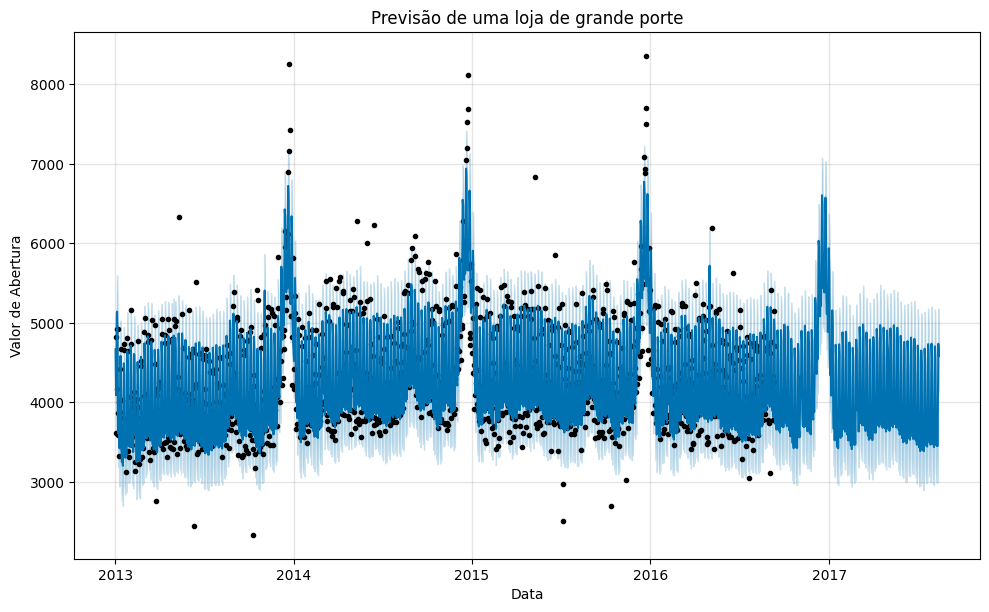

In [11]:
# Criar um novo DataFrame filtrando os valores da coluna "store_nbr"
df_grande = transactions[transactions['store_nbr'] == 44]
df_grande['date'] = pd.to_datetime(df_grande['date'])

# Renomeie as colunas para o formato esperado pelo Prophet
df_grande = df_grande.rename(columns={'date': 'ds', 'transactions': 'y'})

# Determine a proporção de divisão para treino e teste
proporcao_treino = 0.8  # 80% de dados para treino

# Calcule o índice de corte para dividir os dados
tamanho_treino = int(len(df_grande) * proporcao_treino)

# Separe os dados de treino e teste
df_train = df_grande.iloc[:tamanho_treino]  # Dados de treino
df_test = df_grande.iloc[tamanho_treino:]   # Dados de teste

# Crie e ajuste o modelo Prophet com os dados de treino
model = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)
model.add_country_holidays(country_name='EC')
model.fit(df_train)

# Crie um DataFrame para prever as datas futuras com base no tamanho dos dados de teste
future = model.make_future_dataframe(periods=len(df_test))

# Faça previsões para as datas futuras
forecast = model.predict(future)

# Visualize as previsões
fig = model.plot(forecast)
plt.title('Previsão de uma loja de grande porte')
plt.xlabel('Data')
plt.ylabel('Valor de Abertura')
plt.show()

In [12]:
# Avalie as previsões comparando com os dados de teste
test_results = forecast[['ds', 'yhat']].iloc[-len(df_test):]
comparison_df = df_test.set_index('ds').join(test_results.set_index('ds'))

# Verifique se há valores ausentes
print(comparison_df.isna().sum())

# Remova valores ausentes
comparison_df = comparison_df.dropna()

store_nbr    0
y            0
cluster      0
yhat         2
dtype: int64


In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np

# Assumindo que 'comparison_df' está definido e contém colunas 'y' (valores reais) e 'yhat' (previsões)
# e que não contém valores ausentes

# Calcule o RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(comparison_df['y'], comparison_df['yhat']))
print(f'RMSE: {rmse}')

# Calcule o MAE (Mean Absolute Error)
mae = mean_absolute_error(comparison_df['y'], comparison_df['yhat'])
print(f'MAE: {mae}')

# Filtrar valores zero em y e as correspondentes previsões yhat
valid_indices = comparison_df['y'] != 0
y_filtered = comparison_df['y'][valid_indices]
yhat_filtered = comparison_df['yhat'][valid_indices]

# Calcular o MAPE filtrado
mape = mean_absolute_percentage_error(y_filtered, yhat_filtered) * 100

print(f'MAPE (sem valores zero em y): {mape}%')

# Calcule a acurácia como 100% menos o MAPE
accuracy = 100 - mape
print(f'Acurácia do modelo (sem valores zero em y): {accuracy:.2f}%')



RMSE: 491.5925135329916
MAE: 379.9765956643687
MAPE (sem valores zero em y): 8.10609561115015%
Acurácia do modelo (sem valores zero em y): 91.89%


## Loja de Pequeno porte

In [14]:
transactions[transactions['store_nbr'] == 22]

,date,store_nbr,transactions,cluster
48014,2015-10-09,22,2412,0
48067,2015-10-10,22,2008,0
48120,2015-10-11,22,1725,0
48173,2015-10-12,22,1559,0
48226,2015-10-13,22,1312,0
...,...,...,...,...
83239,2017-08-11,22,701,0
83293,2017-08-12,22,888,0
83347,2017-08-13,22,701,0
83401,2017-08-14,22,794,0


<ipython-input-15-180e61d12965>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_novo['date'] = pd.to_datetime(df_novo['date'])
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaxps5sz7/dhiawrhv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaxps5sz7/_yxhfm1v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80694', 'data', 'file=/tmp/tmpaxps5sz7/dhiawrhv.json', 'init=/tmp/tmpaxps5sz7/_yxhfm1v.json', 'output', 'file=/tmp/tmpaxps5sz7/prophet_models7vn8m7o/prophet_model-20240412023844.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:38:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:c

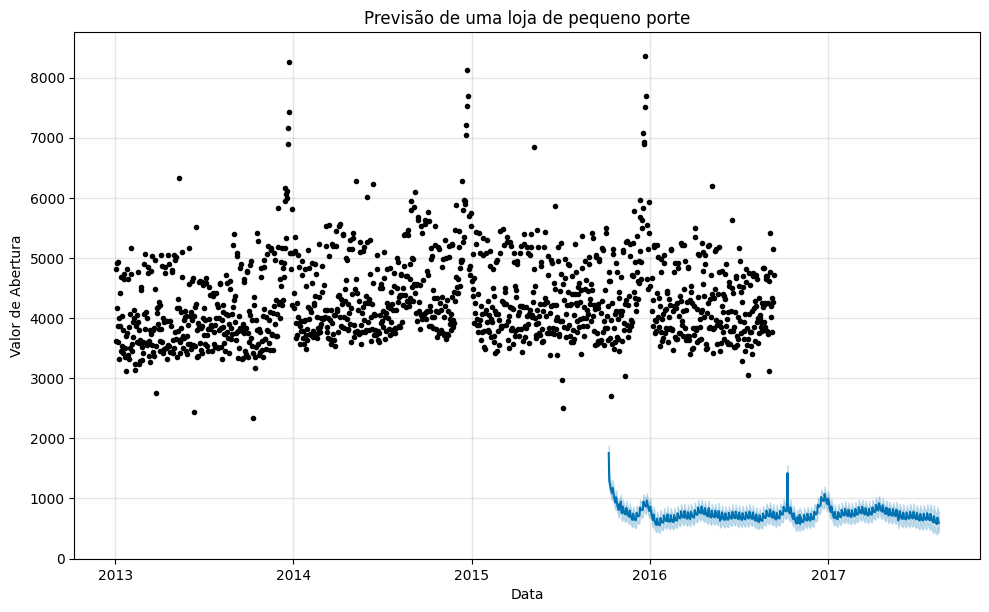

In [15]:
# Criar um novo DataFrame filtrando os valores da coluna "store_nbr"
df_novo = transactions[transactions['store_nbr'] == 22]
df_novo['date'] = pd.to_datetime(df_novo['date'])

# Renomeie as colunas para o formato esperado pelo Prophet
df_novo = df_novo.rename(columns={'date': 'ds', 'transactions': 'y'})

# Determine a proporção de divisão para treino e teste
proporcao_treino = 0.8  # 80% de dados para treino

# Calcule o índice de corte para dividir os dados
tamanho_treino = int(len(df_novo) * proporcao_treino)

# Separe os dados de treino e teste
df_train_p = df_novo.iloc[:tamanho_treino]  # Dados de treino
df_test_p = df_novo.iloc[tamanho_treino:]   # Dados de teste

# Crie e ajuste o modelo Prophet com os dados de treino
m = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)
m.add_country_holidays(country_name='EC')
m.fit(df_train_p)

# Crie um DataFrame para prever as datas futuras com base no tamanho dos dados de teste
future1 = m.make_future_dataframe(periods=len(df_test_p))

# Faça previsões para as datas futuras
forecast1 = m.predict(future1)

# Visualize as previsões
fig = model.plot(forecast1)
plt.title('Previsão de uma loja de pequeno porte')
plt.xlabel('Data')
plt.ylabel('Valor de Abertura')
plt.show()

In [16]:
# Avalie as previsões comparando com os dados de teste
test_results1 = forecast1[['ds', 'yhat']].iloc[-len(df_test_p):]
comparison_df1 = df_test_p.set_index('ds').join(test_results1.set_index('ds'))

# Verifique se há valores ausentes
print(comparison_df1.isna().sum())

# Remova valores ausentes
comparison_df1 = comparison_df1.dropna()

store_nbr    0
y            0
cluster      0
yhat         0
dtype: int64


In [17]:
if not (comparison_df1['y'] == 0).any():
    mape1 = mean_absolute_percentage_error(comparison_df1['y'], comparison_df1['yhat']) * 100
    print(f'MAPE: {mape1}%')

    # Calcule a acurácia como 100% menos o MAPE
    accuracy = 100 - mape1
    print(f'Acurácia do modelo: {accuracy:.2f}%')
else:
    print('MAPE não pôde ser calculado devido a valores zero em "y"')

MAPE: 10.317121012626362%
Acurácia do modelo: 89.68%
